In [44]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'

import pdb
import numpy as np
import trimesh
import pyrender
from pyrender import RenderFlags as RF
from PIL import Image
import matplotlib.pyplot as plt

In [65]:
# Returns matrices for x,y,z rotations
def rotation_matrices(thetas):
    if len(thetas)==1:
        thetas = thetas*3
    theta_x, theta_y, theta_z = thetas
    c_x = np.cos(theta_x)
    s_x = np.sin(theta_x)
    c_y = np.cos(theta_y)
    s_y = np.sin(theta_y)
    c_z = np.cos(theta_z)
    s_z = np.sin(theta_z)
    # s = np.sqrt(2)/2
    x_rot = np.array([
       [1.0,  0.0,  0.0,  0.0],
       [0.0,  c_x,   -s_x,  0.0],
       [0.0,  s_x,    c_x,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])
    y_rot = np.array([
       [c_y,  0.0,  s_y,  0.0],
       [0.0,  1.0,  0.0,  0.0],
       [-s_y,  0.0,  c_y,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])
    z_rot = np.array([
       [c_z,  -s_z,  0.0,  0.0],
       [s_z,  c_z,  0.0,  0.0],
       [0.0,  0.0,  1.0,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])    
    return x_rot, y_rot, z_rot

def rotation_matrix_x(theta):
    c_x = np.cos(theta)
    s_x = np.sin(theta)
    x_rot = np.array([
       [1.0,  0.0,  0.0,  0.0],
       [0.0,  c_x,   -s_x,  0.0],
       [0.0,  s_x,    c_x,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])
    return x_rot

def rotation_matrix_y(theta):
    c_y = np.cos(theta)
    s_y = np.sin(theta)
    y_rot = np.array([
       [c_y,  0.0,  s_y,  0.0],
       [0.0,  1.0,  0.0,  0.0],
       [-s_y,  0.0,  c_y,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])
    return y_rot

def rotation_matrix_z(theta):
    c_z = np.cos(theta)
    s_z = np.sin(theta)
    z_rot = np.array([
       [c_z,  -s_z,  0.0,  0.0],
       [s_z,  c_z,  0.0,  0.0],
       [0.0,  0.0,  1.0,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ]) 
    return z_rot

In [66]:
# Import glb object as scene
def load_object(obj_name):
    obj = trimesh.load(
        f'/fast-vol/ai2thorhab-uncompressed/assets/objects/{obj_name}.glb',
        file_type='glb',
    )
    obj = pyrender.Scene.from_trimesh_scene(obj)
    # pdb.set_trace()
    return obj
    
# Initialize pyrender camera and pose
def create_camera(scene):
    z_shift = np.max(scene.bounds[1]-scene.bounds[0]) / np.tan(np.pi/6)
    y_shift = (scene.bounds[1][1]-scene.bounds[0][1]) / 2
    # print(zoomout)
    
    # Initialize camera
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
    cam_pose = np.array([
       [1.0,  0.0,  0.0,  0.0],
       [0.0,  1.0,  0.0,  y_shift],
       [0.0,  0.0,  1.0,  z_shift*1.25],
       [0.0,  0.0,  0.0,  1.0],
    ])
    # print(camera.get_projection_matrix())

    # Initialize lights
    cam_light = pyrender.SpotLight(
        color=np.ones(3), intensity=5.0,
        innerConeAngle=np.pi/16.0, outerConeAngle=np.pi/6.0
    )
    overhead_light = pyrender.PointLight(color=np.ones(3), intensity=15.0)
    overhead_pose = np.array([
       [1.0,  0.0,  0.0,  0.0],
       [0.0,  1.0,  0.0,  y_shift*5],
       [0.0,  0.0,  1.0,  0.0],
       [0.0,  0.0,  0.0,  1.0],
    ])
    lights = [cam_light, overhead_light]
    return camera, cam_pose, lights, overhead_pose

# Render object given its file name
def render_object(obj_filename):
    # Get object, camera, light
    scene = load_object(obj_filename)
    camera, camera_pose, lights, overhead_pose = create_camera(scene)
    camera_node = scene.add(camera, pose=camera_pose)
    cam_light_node = scene.add(lights[0], pose=camera_pose)
    overhead_node = scene.add(lights[1], pose=overhead_pose)

    # The main render loop through all angles:
    
    # Control object angle/position
    k = [4,8,6,3] # How many rotations to go in a full circle, per axis -- (x,y,z,num_x_rings)
    x_rots = [rotation_matrix_x(theta) for theta in [-np.pi/k[0], 0, np.pi/k[0]]]
    assert len(x_rots)==k[3]
    y_rot = rotation_matrix_y(2*np.pi / k[1])
    z_rot = rotation_matrix_z(2*np.pi / k[2])
    
    # Store initial pose
    start_poses = [scene.get_pose(node) for node in scene.nodes]
    r = pyrender.OffscreenRenderer(256, 256)
    renders = []
    
    # View object from above, below, etc (pitch)
    for x_rot in x_rots:
        # Rotate object 360 degrees wrt y-axis (yaw)
        for n in range(0,k[1]): 
            # Set new pose
            apply_pose = \
                np.linalg.matrix_power(y_rot,n) @ \
                x_rot
            for i,node in enumerate(scene.nodes):
                if node.camera is None and node is not cam_light_node:
                    start_pose = start_poses[i]
                    scene.set_pose(node, pose=apply_pose@start_pose)
            # Render    
            color, depth = r.render(scene) #, flags=RF.SHADOWS_DIRECTIONAL
            color = Image.fromarray(color)
            renders.append(color)
            # depth = Image.fromarray(np.uint8(depth), 'L')
            # renders.append(depth)
    
    return renders, k

# Display all renders of an object
def display_renders(renders, k, obj_name=None, cell_size=2):
    fig = plt.figure(figsize=(k[1]*cell_size,k[3]*cell_size))
    
    for i,img in enumerate(renders):
        plt.subplot(k[3],k[1],i+1)
        plt.axis('on')
        plt.imshow(img)

    if obj_name is not None:
        fig.suptitle(obj_name)
        
    plt.show()
    return fig

Object Bed_30 has 24 rendered images.


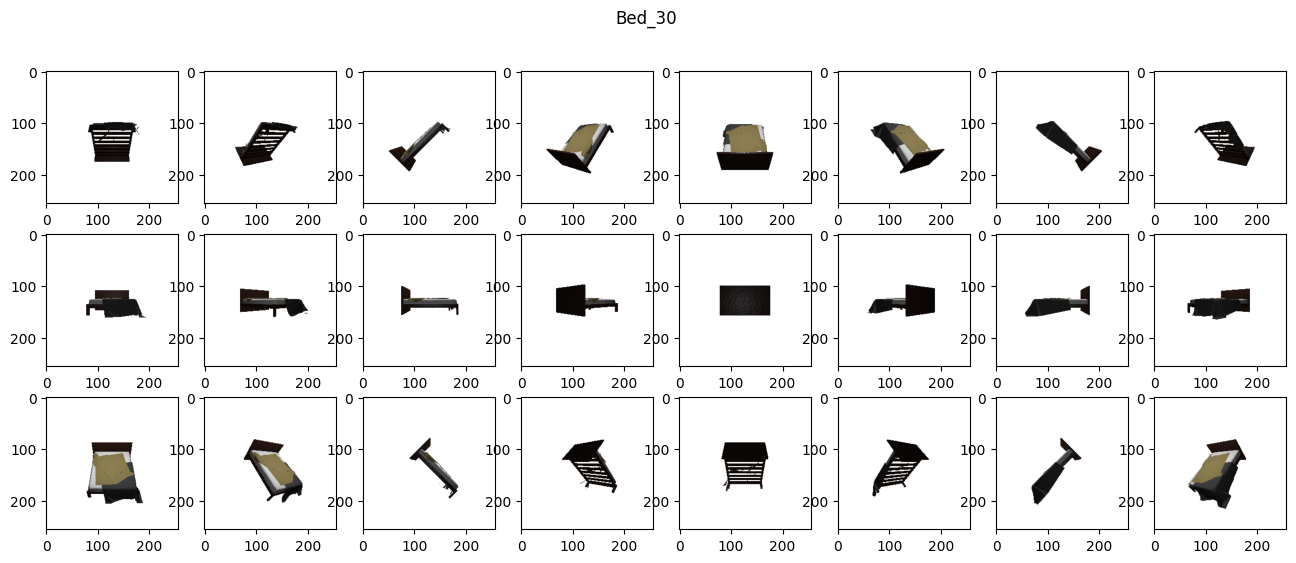

Object Alarm_Clock_17 has 24 rendered images.


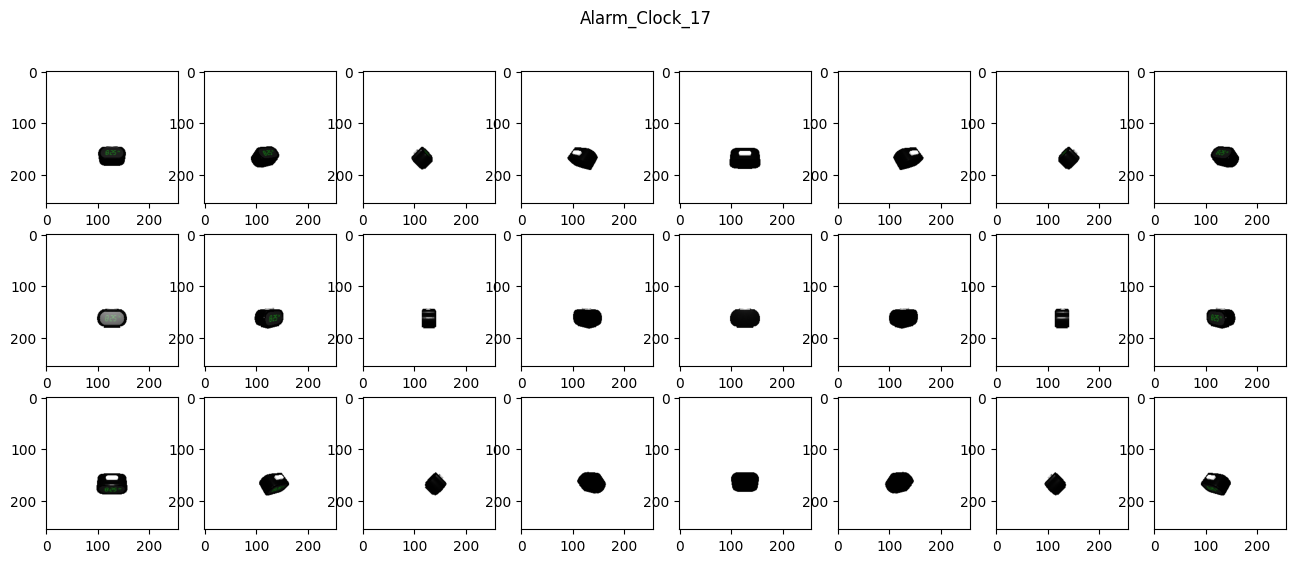

Object Armchair_208_2 has 24 rendered images.


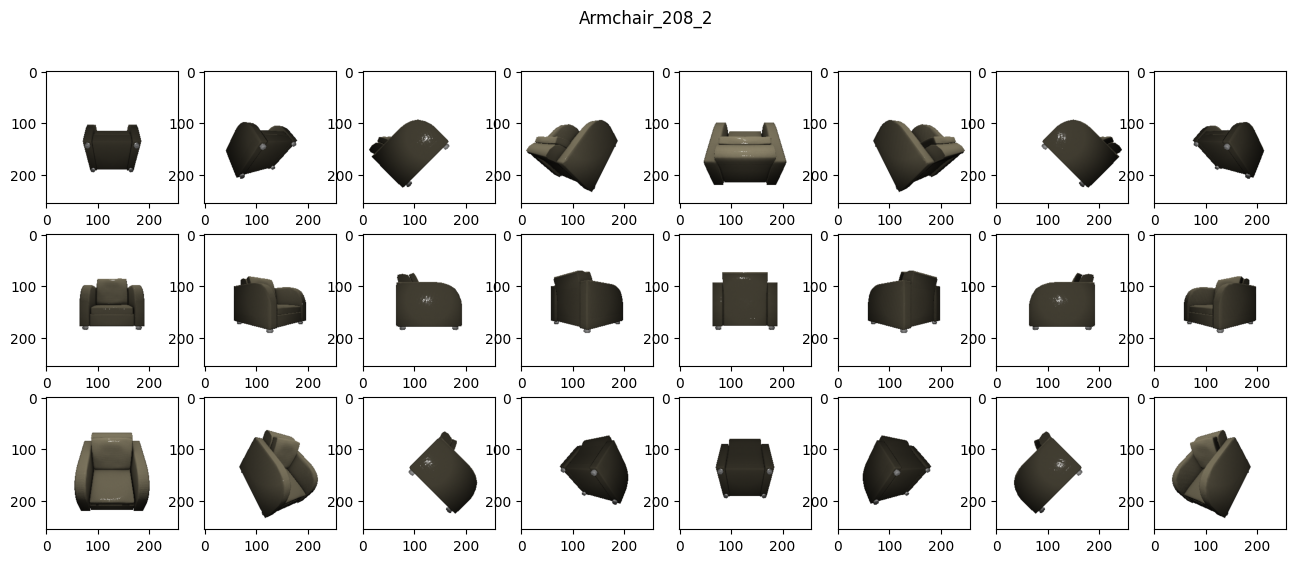

In [67]:
# %%timeit
obj_names = ["Bed_30", "Alarm_Clock_17", "Armchair_208_2"]

for name in obj_names:
    # Rendering
    renders, k = render_object(name)
    print(f"Object {name} has {len(renders)} rendered images.")

    # Display
    _ = display_renders(renders, k, name)

    # Optional: save renders
    # for i,img in enumerate(renders):
    #     img.save(f"./renders/{name}-{i}.png")
